In [3]:
import pandas as pd
import numpy
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

In [4]:
df = pd.read_csv('kpi_vhkt.csv')

In [5]:
df.rename(columns = {'sum_duration':'total_duration'}, inplace = True)
df

,date,phong_ban,total_duration
0,2020-01-01,wo_co_dien,59856.56
1,2020-01-01,wo_others,308.45
2,2020-01-01,wo_ksnn,682.55
3,2020-01-01,wo_noc,1825.36
4,2020-01-02,wo_noc,4725.20
...,...,...,...
7805,2023-12-30,wo_noc,9872.19
7806,2023-12-31,wo_others,24601.24
7807,2023-12-31,wo_noc,9844.20
7808,2023-12-31,wo_ksnn,57173.30


In [6]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]

# Print duplicate rows
print("Duplicate Rows:")
print(duplicate_rows)

Duplicate Rows:
Empty DataFrame
Columns: [date, phong_ban, total_duration]
Index: []


In [169]:
df.drop_duplicates(inplace=True)

In [170]:
df

,date,phong_ban,total_duration
0,2020-01-01,wo_co_dien,59856.56
1,2020-01-01,wo_others,308.45
2,2020-01-01,wo_ksnn,682.55
3,2020-01-01,wo_noc,1825.36
4,2020-01-02,wo_noc,4725.20
...,...,...,...
7805,2023-12-30,wo_noc,9872.19
7806,2023-12-31,wo_others,24601.24
7807,2023-12-31,wo_noc,9844.20
7808,2023-12-31,wo_ksnn,57173.30


# Preprocessing data

## Sort by date

In [7]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='date')
df

,date,phong_ban,total_duration
0,2020-01-01,wo_co_dien,59856.56
1,2020-01-01,wo_others,308.45
2,2020-01-01,wo_ksnn,682.55
3,2020-01-01,wo_noc,1825.36
4,2020-01-02,wo_noc,4725.20
...,...,...,...
7803,2023-12-30,wo_ksnn,62641.27
7807,2023-12-31,wo_noc,9844.20
7808,2023-12-31,wo_ksnn,57173.30
7806,2023-12-31,wo_others,24601.24


# Split data into Phong Ban

In [8]:
df = pd.DataFrame(df)

# Tạo các nhóm dựa trên phòng ban
grouped = df.groupby('phong_ban')
# Hiển thị các nhóm
for name, group in grouped:
    print("Phòng ban:", name)
    print(group)
# Tạo một từ điển để lưu trữ các DataFrame của từng phòng ban
phong_ban_dict = {}
# Tạo các DataFrame cho từng phòng ban và lưu vào từ điển
for name, group in df.groupby('phong_ban'):
    phong_ban_dict[name] = group

Phòng ban: wo_co_dien
            date   phong_ban  total_duration
0     2020-01-01  wo_co_dien        59856.56
7     2020-01-02  wo_co_dien       205396.18
8     2020-01-03  wo_co_dien       238813.40
14    2020-01-04  wo_co_dien       263309.13
19    2020-01-05  wo_co_dien       281805.86
...          ...         ...             ...
7791  2023-12-27  wo_co_dien          585.66
7794  2023-12-28  wo_co_dien          391.99
7801  2023-12-29  wo_co_dien          291.98
7802  2023-12-30  wo_co_dien          234.24
7809  2023-12-31  wo_co_dien          342.89

[1461 rows x 3 columns]
Phòng ban: wo_ksnn
            date phong_ban  total_duration
2     2020-01-01   wo_ksnn          682.55
5     2020-01-02   wo_ksnn         1611.54
9     2020-01-03   wo_ksnn         1776.64
13    2020-01-04   wo_ksnn         1981.34
17    2020-01-05   wo_ksnn         2008.04
...          ...       ...             ...
7793  2023-12-27   wo_ksnn        79821.50
7796  2023-12-28   wo_ksnn        74093.16
7799  2

## save data frame by Phong Ban

In [9]:
df_wo_co_dien = phong_ban_dict['wo_co_dien']
df_wo_ksnn = phong_ban_dict['wo_ksnn']
df_wo_ktts = phong_ban_dict['wo_ktts']
df_wo_noc = phong_ban_dict['wo_noc']
df_wo_vt_cntt = phong_ban_dict['wo_vt_cntt']
df_wo_others = phong_ban_dict['wo_others']

# Training model with Phong Ban : wo_noc

## Preprocessing data

### sum total duration by "day"

In [10]:
# Nhóm dữ liệu theo ngày và tính tổng thời gian
df_wo_noc = df_wo_noc.groupby('date')['total_duration'].sum()

# Tạo DataFrame mới từ kết quả
df_wo_noc = pd.DataFrame(df_wo_noc, columns=['date', 'total_duration'])
df_wo_noc.drop('date',axis=1,inplace=True)
df_wo_noc

,total_duration
date,
2020-01-01,1825.36
2020-01-02,4725.20
2020-01-03,9869.28
2020-01-04,11700.22
2020-01-05,13324.29
...,...
2023-12-27,11723.09
2023-12-28,10208.14
2023-12-29,10022.66


## build model LSTM

## Visualize

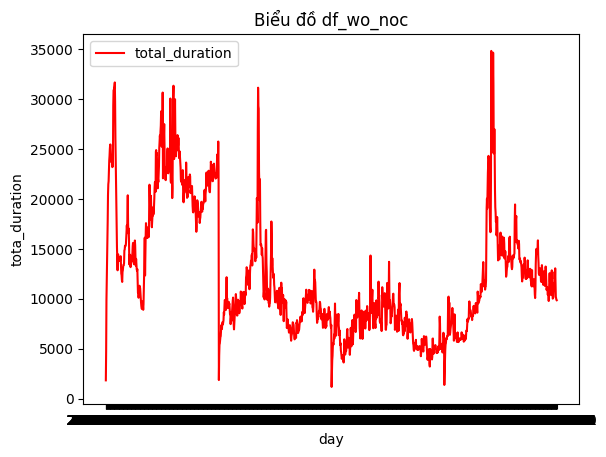

In [11]:
plt.plot(df_wo_noc.index, df_wo_noc['total_duration'], label='total_duration', color='red')
plt.xlabel('day')
plt.ylabel('tota_duration')
plt.title('Biểu đồ df_wo_noc')
plt.legend(loc='best')

In [12]:
df_wo_noc.shape

(1461, 1)

In [13]:
#chia tập dữ liệu
data = df_wo_noc.values
train_data = data[:800]
test_data = data[800:]

In [14]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [15]:
#tạo vòng lặp các giá trị
mark = 30
x_train,y_train=[],[]
for i in range(mark,len(train_data)):
  x_train.append(sc_train[i-mark:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [16]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

In [17]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

2024-02-22 16:27:10.870876: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 16:27:10.872486: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
#huấn luyện mô hình
save_model = "save_model.hdf5"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=80,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.15149, saving model to save_model.hdf5
16/16 - 3s - loss: 0.1515 - 3s/epoch - 189ms/step
Epoch 2/80


/home/huydq/anaconda3/envs/vhkt/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: loss improved from 0.15149 to 0.08384, saving model to save_model.hdf5
16/16 - 0s - loss: 0.0838 - 238ms/epoch - 15ms/step
Epoch 3/80

Epoch 3: loss improved from 0.08384 to 0.07408, saving model to save_model.hdf5
16/16 - 0s - loss: 0.0741 - 227ms/epoch - 14ms/step
Epoch 4/80

Epoch 4: loss improved from 0.07408 to 0.06895, saving model to save_model.hdf5
16/16 - 1s - loss: 0.0689 - 957ms/epoch - 60ms/step
Epoch 5/80

Epoch 5: loss improved from 0.06895 to 0.06710, saving model to save_model.hdf5
16/16 - 0s - loss: 0.0671 - 265ms/epoch - 17ms/step
Epoch 6/80

Epoch 6: loss did not improve from 0.06710
16/16 - 0s - loss: 0.0675 - 222ms/epoch - 14ms/step
Epoch 7/80

Epoch 7: loss improved from 0.06710 to 0.06616, saving model to save_model.hdf5
16/16 - 0s - loss: 0.0662 - 231ms/epoch - 14ms/step
Epoch 8/80

Epoch 8: loss improved from 0.06616 to 0.06307, saving model to save_model.hdf5
16/16 - 0s - loss: 0.0631 - 228ms/epoch - 14ms/step
Epoch 9/80

Epoch 9: loss improved from 

In [19]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("save_model.hdf5")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

25/25 [==============================] - 0s 5ms/step


In [21]:

#xử lý dữ liệu test
test = df_wo_noc[len(train_data)-mark:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(mark,test.shape[0]):
  x_test.append(sc_test[i-mark:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[800:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

21/21 [==============================] - 0s 5ms/step


/tmp/ipykernel_2921293/2865306125.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
/tmp/ipykernel_2921293/2865306125.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


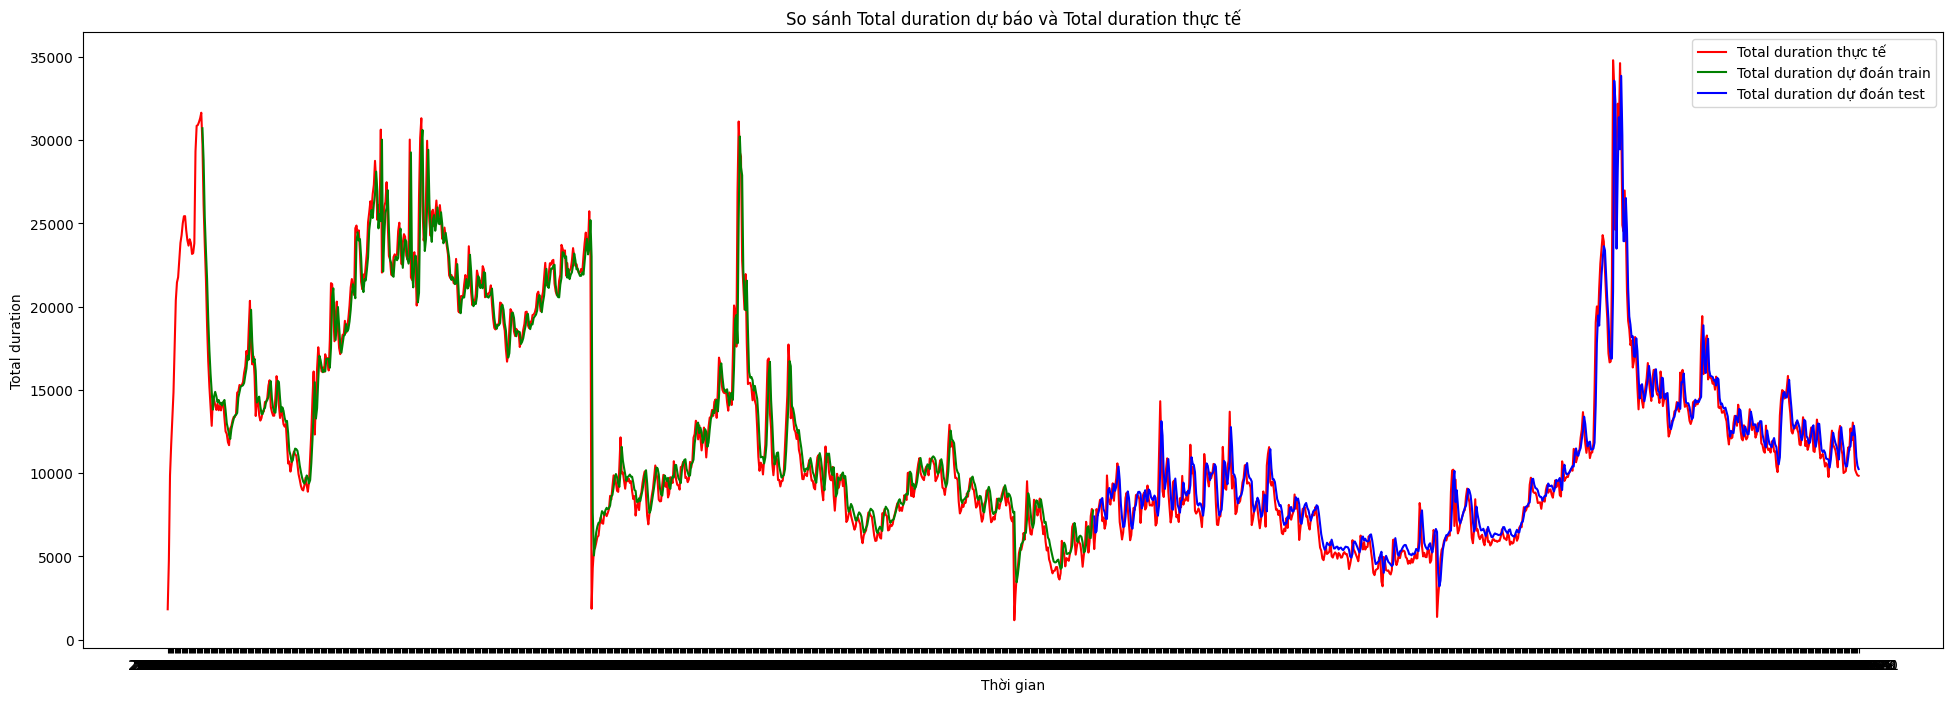

In [22]:
#lập biểu đồ so sánh
train_data1 = df_wo_noc[mark:800]
test_data1 = df_wo_noc[800:]

plt.figure(figsize=(24,8))
plt.plot(df_wo_noc,label='Total duration thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Total duration dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Total duration dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh Total duration dự báo và Total duration thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Total duration') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [192]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9569983498068771
Sai số tuyệt đối trung bình trên tập train (VNĐ): 4916.803712129667
Phần trăm sai số tuyệt đối trung bình tập train: 0.0980548549983062


In [193]:
train_data1

,total_duration,Dự đoán
date,,
2020-01-31,8367.17,7476.101074
2020-02-01,8269.20,6873.606445
2020-02-02,12647.71,6780.375488
2020-02-03,14143.91,10448.969727
2020-02-04,14860.27,12415.443359
...,...,...
2022-03-06,33217.83,32661.626953
2022-03-07,32343.37,31332.363281
2022-03-08,31542.42,30383.583984


In [194]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9343581389200316
Sai số tuyệt đối trung bình trên tập test (VNĐ): 2269.2571832815565
Phần trăm sai số tuyệt đối trung bình tập test: 0.1264776904903641


In [195]:
test_data1

,total_duration,Dự đoán
date,,
2022-03-11,29006.62,27500.648438
2022-03-12,28100.86,26959.337891
2022-03-13,27565.53,26115.597656
2022-03-14,27244.67,25546.476562
2022-03-15,27150.85,25208.791016
...,...,...
2023-12-27,585.66,-315.627350
2023-12-28,391.99,-448.651031
2023-12-29,291.98,-624.133362


In [158]:
pip list

Package                      Version
---------------------------- ---------------
absl-py                      2.1.0
anyio                        4.3.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.14.0
beautifulsoup4               4.12.3
bleach                       6.1.0
cachetools                   5.3.2
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
comm                         0.2.1
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
defusedxml                   0.7.1
et-xmlfile                   1.1.0
exceptiongroup               1.2.0
executing                    2.0.1
fastjsonschema               2.19

# future prediction

In [35]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Ngày'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Đóng cửa'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Ngày': [next_date], 'Đóng cửa': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Ngày'], df1['Đóng cửa'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()

KeyError: 'Ngày'

In [159]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 128)           66560     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116033 (453.25 KB)
Trainable params: 116033 (453.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
